# Loading libraries and data

In [1]:
# Data structure libraries
import numpy as np
import pandas as pd
from datatable import dt
import datetime

# Graphing Libraries
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Timeseries prediction libraries
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm

# Evaluation libraries
from sklearn.metrics import mean_squared_error

# Garbage collection
# import gc

In [2]:
# Loading data
df = dt.fread("../input/tsdata-1/passengers_train.csv").to_pandas()

# EDA (Exploratory Data Analysis)

In [3]:
print(df.head(5))

   ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2


In [4]:
# Describe the Count variable, get the quartiles and mean
print(df["Count"].describe())

count    18288.000000
mean       138.958115
std        153.467461
min          2.000000
25%         22.000000
50%         84.000000
75%        210.000000
max       1244.000000
Name: Count, dtype: float64


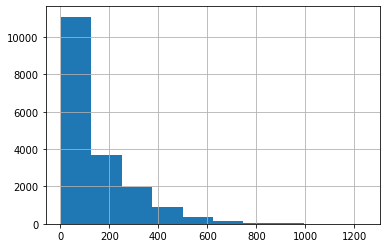

In [5]:
# Plot the histogram of Count variable
df.Count.hist()
plt.show()

In [6]:
# Replacing outliners with 99 percentile values
# max_value = df.quantile(0.99)['Count']
# df['Count'] = np.where(df['Count'] > max_value, max_value, df['Count'])

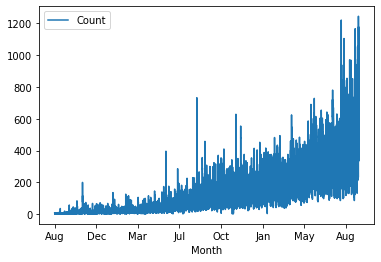

In [7]:
# Plot the Count variable with respect to month
df['Month'] = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M').dt.strftime('%b')
df.plot( 'Month' , 'Count' )
# Remove the Month variable
df = df.drop(['Month'], axis=1)

# Feature Engineering

In [8]:
# Divide the data into train and test
train_length = 16464
train = df[0:train_length]
test = df[train_length:]

In [9]:
# Aggregate the data to get average count per hour
df.attrs['Timestamp'] = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.attrs['Timestamp'] 
df = df.resample('D').mean()
train.attrs['Timestamp'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.attrs['Timestamp'] 
train = train.resample('D').mean() 
test.attrs['Timestamp'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.attrs['Timestamp']
test = test.resample('D').mean()

In [10]:
train.head(3)

ID     Count
Datetime                  
2012-08-25  11.5  3.166667
2012-08-26  35.5  3.666667
2012-08-27  59.5  2.583333

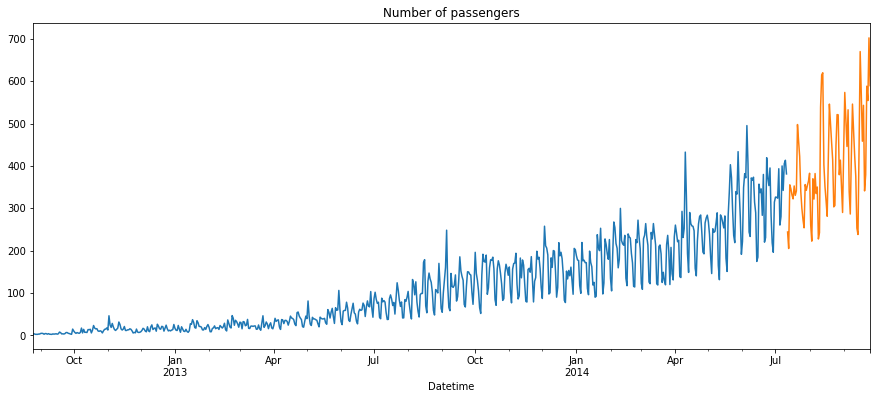

In [11]:
# Plotting data
train.Count.plot(figsize=(15,6),title= 'Number of passengers')
test.Count.plot(figsize=(15,6),title= 'Number of passengers')
plt.show()

In [12]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Count'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
# result_add = seasonal_decompose(df['Count'], model='additive', extrapolate_trend='freq')

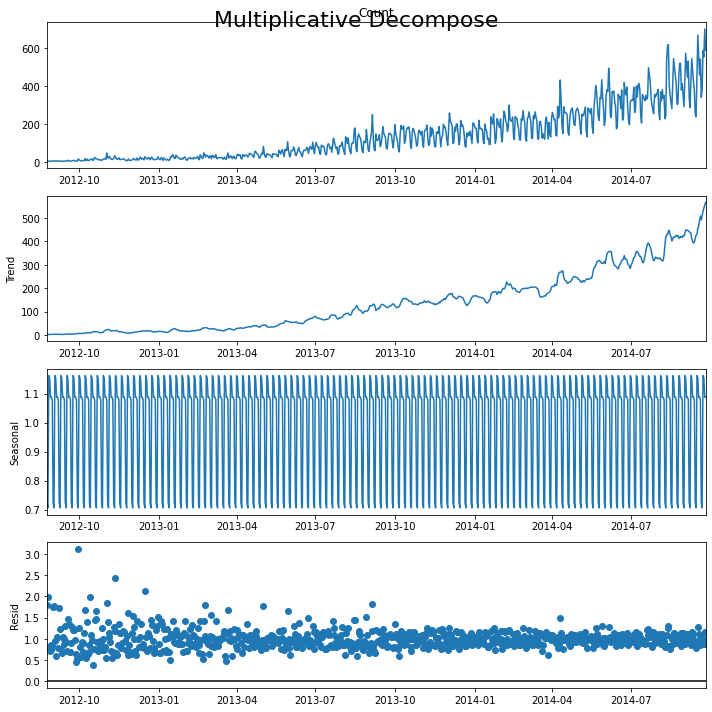

In [13]:
# Plot the trend, seasonal fluctions, and residuals
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

# Prediction Models

In [14]:
# Holt Winters
y_hat_avg = test.copy()
# Create a model based on week data (seasonal_periods=7)
fit1 = ExponentialSmoothing(np.asarray(train['Count']), seasonal_periods=7, trend='add', seasonal='add',).fit()
# Generate predictions
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

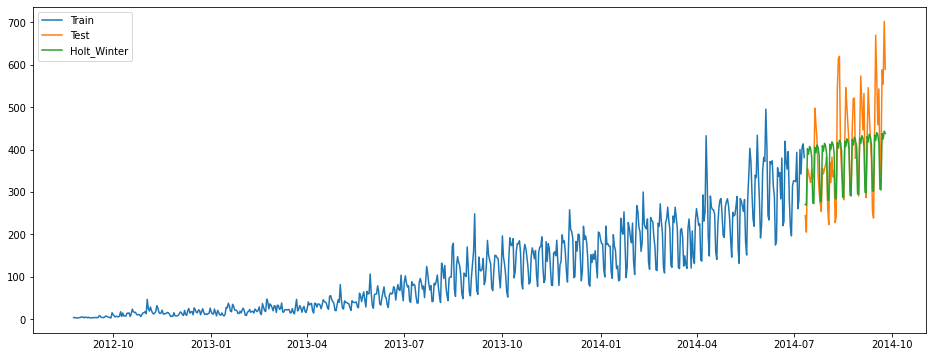

In [15]:
# Plot the train, test and predictions of Holt Winters models
plt.figure(figsize=(16,6))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [16]:
# Calculate the root mean squared error for Holt Winter
rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rmse)

85.46835629234155


In [17]:
# SArima
y_hat_avg = test.copy()
# Create a model based on week data (seasonal_periods=7)
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 2, 3),seasonal_order=(0,1,1,7)).fit()
# Generate predictions
y_hat_avg['SARIMA'] = fit1.predict(start="2014-07-12", end="2014-09-25", dynamic=True)
# rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
# print(rmse)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78242D+00    |proj g|=  4.41793D-02


 This problem is unconstrained.



At iterate    5    f=  4.74523D+00    |proj g|=  2.93413D-02

At iterate   10    f=  4.53691D+00    |proj g|=  5.54898D-02

At iterate   15    f=  4.52849D+00    |proj g|=  6.56249D-03

At iterate   20    f=  4.52791D+00    |proj g|=  4.09226D-04

At iterate   25    f=  4.52771D+00    |proj g|=  1.37408D-03

At iterate   30    f=  4.52767D+00    |proj g|=  2.90104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     50      1     0     0   3.831D-05   4.528D+00
  F =   4.5276660038762797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


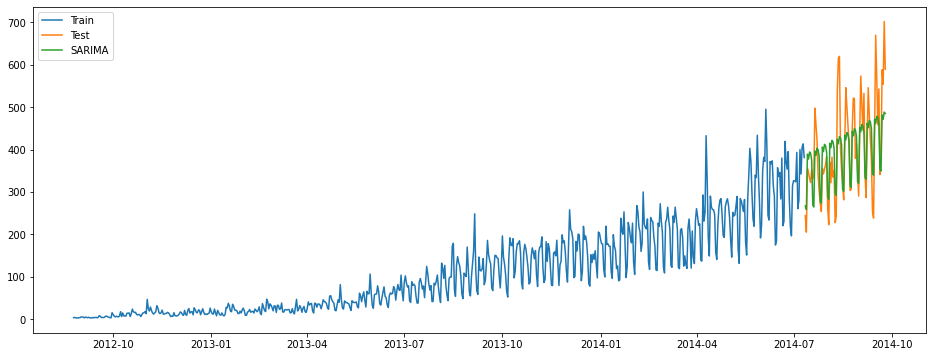

In [18]:
# Plot the train, test and predictions of SARIMA model
plt.figure(figsize=(16,6))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [19]:
# Calculate the root mean squared error for SARIMA
rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print(rmse)

75.18030277831276


In [20]:
# y_hat_avg.head(30)

In [21]:
# Remove unnecesary objects from memory.
# [x for x in dir() if x.lower()]
# del(mean_squared_error, rmse, test, train, auto_cor, fit1, y_hat_avg)

# Final Model

In [22]:
# Train the SArima model on whole data
fit1 = sm.tsa.statespace.SARIMAX(df.Count, order=(2, 2, 3), seasonal_order=(0,1,1,7)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98340D+00    |proj g|=  4.26141D-02


 This problem is unconstrained.



At iterate    5    f=  4.95610D+00    |proj g|=  1.34691D-02

At iterate   10    f=  4.82558D+00    |proj g|=  9.59117D-02

At iterate   15    f=  4.75666D+00    |proj g|=  9.09936D-03

At iterate   20    f=  4.74684D+00    |proj g|=  4.14266D-03

At iterate   25    f=  4.74483D+00    |proj g|=  1.77540D-03

At iterate   30    f=  4.74465D+00    |proj g|=  2.12899D-03

At iterate   35    f=  4.74445D+00    |proj g|=  1.60372D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     47      1     0     0   2.132D-05   4.744D+00
  F =   4.7444479251471998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [23]:
# Function to get the hourly ratio based on weekday
def day_ratio(dt, day):
    ratio = dt.loc[dt["Day"] == day].groupby('Hour')['Count'].mean().to_frame(name = 'Ratio').reset_index()
    ratio['Ratio'] = ratio['Ratio'].div(ratio['Ratio'].sum()).round(4)
    ratio["Day"] = day
    return ratio

In [24]:
# Get week day hourly data
df = dt.fread("../input/tsdata-1/passengers_train.csv").to_pandas()
df['Day'] = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M').dt.strftime('%A')
df['Hour'] = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M').dt.strftime('%H')

hourly_ratio = pd.concat([day_ratio(df, "Monday"),
                         day_ratio(df, "Tuesday"),
                         day_ratio(df, "Wednesday"),
                         day_ratio(df, "Thursday"),
                         day_ratio(df, "Friday"),
                         day_ratio(df, "Saturday"),
                         day_ratio(df, "Sunday")])
print(hourly_ratio.head(3))
# print(hourly_ratio['Day'].value_counts())

  Hour   Ratio     Day
0   00  0.0325  Monday
1   01  0.0252  Monday
2   02  0.0212  Monday


# Submission

In [25]:
# Loading submission data
df_test = dt.fread("../input/tsdata-1/passengers_test.csv").to_pandas()
df_test['Hour'] = pd.to_datetime(df_test.Datetime,format='%d-%m-%Y %H:%M').dt.strftime('%H')
df_test['Date'] = pd.to_datetime(df_test.Datetime, format='%d-%m-%Y %H:%M').dt.date
df_test['Day'] = pd.to_datetime(df_test.Datetime,format='%d-%m-%Y %H:%M').dt.strftime('%A')

df_test = pd.merge(df_test, hourly_ratio, on=['Hour','Day'], how='left')
print(df_test.head(2))

      ID          Datetime Hour        Date     Day   Ratio
0  18288  26-09-2014 00:00   00  2014-09-26  Friday  0.0453
1  18289  26-09-2014 01:00   01  2014-09-26  Friday  0.0363


In [26]:
# Predict daily test data.
daily_predictions = fit1.predict(start="2014-09-26", end="2015-04-26", dynamic=True).to_frame(name = 'Count').reset_index()

daily_predictions['Date'] = pd.to_datetime(daily_predictions['index']).dt.date
df_test = pd.merge(df_test, daily_predictions, left_on='Date', right_on='Date', how='left')
df_test['Count'] = np.ceil(df_test['Ratio'] * df_test['Count'])
# df_test.head(3)

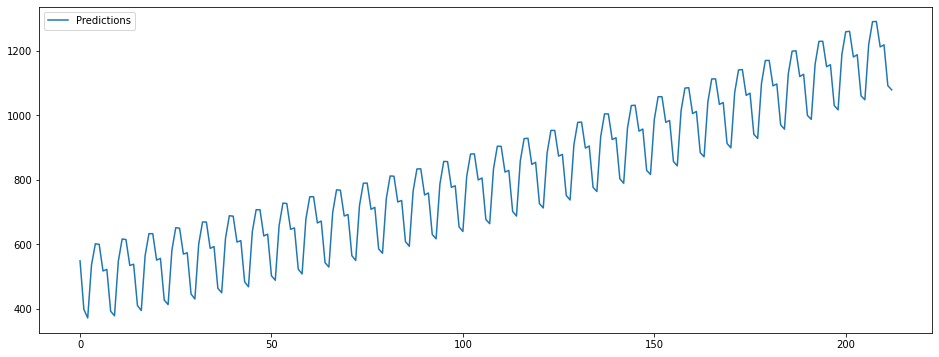

In [27]:
# Plot of predictions
plt.figure(figsize=(16,6))
plt.plot(daily_predictions['Count'], label='Predictions')
plt.legend(loc='best')
plt.show()

In [28]:
# Filter ID and Count columns
df_test = df_test[['ID', 'Count']]
# Transforming average hourly count to daily count 
df_test['Count'] = df_test['Count'].astype(int) * 24
df_test.head(3)

ID  Count
0  18288    600
1  18289    480
2  18290    408

In [29]:
# Check the prediction data
print(df_test.head(3))

      ID  Count
0  18288    600
1  18289    480
2  18290    408


In [30]:
# Check for NULL values
print(df_test[df_test.isna().any(axis=1)])

Empty DataFrame
Columns: [ID, Count]
Index: []


In [31]:
# Describe the Count column
print(df_test['Count'].describe())

count    5112.000000
mean      825.084507
std       352.682199
min       216.000000
25%       528.000000
50%       792.000000
75%      1080.000000
max      1800.000000
Name: Count, dtype: float64


In [32]:
# Export to CSV
df_test.to_csv("submission.csv", index=False)